# Feature engineering

## Cargando librerías

In [1]:
import pandas as pd
import pickle
from datetime import date, timedelta
import numpy as np

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

### Funciones extra, en utils

In [3]:
def generate_label(df):
    """
    Crea en el data frame de los datos la variable label que es 1
    cuando el código de cierre es 'Pass','Pass w/ Conditions', 0 en caso de 'Fail'.
    :param: dataframe
    :return: dataframe
    """
    df['label'] = np.where(df.results.isin(['Pass','Pass w/ Conditions']), 1, 0)
    return df

## Funciones de ingesta y transformación

In [4]:
# Funciones solicitadas

def load_ingestion(path='output/ingest_df.pkl'):
    """
    Recibe el path en donde se encuentra el pickle que generamos durante la ingestión.
    :param: path
    :return: pickle
    """
    # Recibe ingest_df.pkl
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)

def date_transformation(col, df):
    """
    Recibe la columna que hay que transformar a DATE y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return pd.to_datetime(df[col])

def numeric_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(float) 

def int_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(int)

def categoric_trasformation(col, df):
    """
    Recibe la columna que hay que transformar a CATEGORICA y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(str) 


def split_fecha(col, df):
    """
    Recibe la columna fecha que hay que transformar en 3 columnas: año, mes, dia y 
    el data frame al que pertenece.
    :param: column, dataframe
    :return: dataframe con 2 columnas mas (mes, día)
    """
    #df[col + '_año'] = df[col].dt.year.astype(str) 
    df[col + '_mes'] = df[col].dt.month.astype(str) 
    df[col + '_dia'] = df[col].dt.day.astype(str)     
    
    # Cambio a enteros
    df[col + '_mes'] = int_transformation(col + '_mes', df)
    df[col + '_dia'] = int_transformation(col + '_dia', df)
    # Como strings
    #df[col + '_mes'] = df[col + '_mes'].apply(two_dig)
    #df[col + '_dia'] = df[col + '_dia'].apply(two_dig)
    
    return df
  
def save_transformation(df, path='output/transformation_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb)
    el data frame que ya tiene los datos transformados.
    El pickle se debe llamar transformation_df.pkl y se debe guardar
    en la carpeta output.
    :param: dataframe, path
    :return: file save
    """
    pickle.dump(df, open(path, "wb"))
    # utils function, debería guardar el pickle llamado transformation_df.pkl en la carpeta ouput
    # save_df(df, path)

## Funciones de feature enginering

In [37]:
# Funciones solicitadas

def load_transformation(path='output/transformation_df.pkl'): 
    """
    Recibe el path en donde se encuentra el pickle que generamos 
    durante la transformación.
    """
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def feature_generation(data): 
    """
    Recibe el data frame que contiene las variables a partir de las cuales 
    crearemos nuevas variables. Estas nuevas variables se guardarán en este 
    mismo data frame.
    """    
    
    # Para crear variables ciclícas
    data = ciclic_variables('day_of_week', data)
    data = ciclic_variables('week', data)
    data = ciclic_variables('inspection_date_mes', data)
    data = ciclic_variables('inspection_date_dia', data)
    
    # Se quita 'dba_name','address'
    # Se quedan sin transformar 'inspection_date','label'
    
    # Variables posibles a transformar
    """
    'facility_type','type','risk','city','state','zip','results','latitude','longitude',
    'sin_day_no','cos_day_no','sin_week','cos_week','sin_month','cos_month','sin_days','cos_days'
    """
    
    # Variables a transformar
    data_input = pd.DataFrame(data,
                              columns=['type','risk','zip',#'results',
                                       'latitude','longitude',
                                       'sin_day_no','cos_day_no','sin_week','cos_week',
                                       'sin_month','cos_month','sin_days','cos_days'])
    # Transformaciones
    transformers_2 = [('one_hot', OneHotEncoder(), ['type','risk','zip']),#,'results']),
                      ('min_max', MinMaxScaler(), ['latitude','longitude',
                                                   'sin_day_no','cos_day_no','sin_week','cos_week',
                                                   'sin_month','cos_month','sin_days','cos_days'])]

    col_trans_2 = ColumnTransformer(transformers_2, remainder="drop", n_jobs=-1, verbose=True)
    col_trans_2.fit(data_input)

    input_vars = col_trans_2.transform(data_input)

    cols = ['bakery','catering','childern\'s service facility','daycare','golden diner','grocery','hospital',
            'long-term care','otros','restaurant', 'school',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            'latitude','longitude',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

    # Información del dataframe final
    df_final = pd.DataFrame(input_vars.todense())
    df_final.columns = cols    
        
    df_final['inspection_date']= data['inspection_date']
    df_final['label']= data['label']

    return input_vars, df_final
   
    
def feature_selection(input_vars): 
    """
    Recibe el data frame que contiene las variables de las cuales haremos
    una selección.
    """
    X = input_vars
    y = data.label.values.reshape(input_vars.shape[0], )

    np.random.seed(20201124)

    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, random_state=1234)
    # separando en train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # definicion de los hiperparametros que queremos probar, se tarda aprox 3 horas en correr
    hyper_param_grid = {'n_estimators': [100, 300],
                        'max_depth': [1, 10, 15],
                        'min_samples_split': [2, 5]}

    # ocupemos grid search!
    gs = GridSearchCV(classifier,
                      hyper_param_grid,
                      scoring='precision',
                      cv=3,
                      n_jobs=2)

    # ejecutando el RF
    start_time = time.time()
    gs.fit(X_train, y_train)
    print("El proceso en segundos duro: ", time.time() - start_time)
    print("Mejores parámetros: " + str(gs.best_params_))
    print("Score:" + str(print(gs.best_score_)))
    best_e = gs.best_estimator_
    print("Mejor estimador: " + str(best_e))
    print("Mejor estimador observado: " + str(gs.best_estimator_.oob_score_))

    # Importancia de los parámetros
    feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                       'feature': list(final_df.columns)})
    print("Importancia de los parámetros")
    print(feature_importance.sort_values(by="importance", ascending=False))

    # Salvando el mejor modelo obtenido
    save_fe(best_e, path='../output/feature_selection_model.pkl')

    # Regresando dataframe con los features que ocuparemos.
    # En este caso las variables que aportan más del 7% de información son:
    # incidentes_c4, tipo_entrada, latitud y longitud (las 2 primeras se pasaran
    # en OneHotEncoding)
    final_df = final_df[['accidente-ciclista',
                         'BOTÓN DE AUXILIO',
                         'latitud', 
                         'longitud'
                         'RADIO', 
                         'accidente-choque con prensados',
                         'lesionado-atropellado',
                         'LLAMADA DEL 911',
                         'LLAMADA DEL 066',
                         'cos_hr_creacion', 'sin_hr_creacion',
                         'sin_week_no', 'cos_week_no',
                          'sin_day_no', 'cos_day_no'
                         ]]    

    return final_df

    
def save_fe(df, path='output/fe_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb) el data frame 
    que ya tiene los features que ocuparemos. El pickle se debe llamar fe_df.pkl y 
    se debe guardar en la carpeta output.
    """    
    # pickle.dump(df, open(path, "wb"))
    # utils function, debería guardar el picjle llamado fe_df.pkl en la carpeta ouput
    save_df(df, path)
    

# --------------------- Funciones Auxiliares ---------------------------    
def ciclic_variables(col, df):
    """
    Recibe la columna day_no, mes o fecha_creacion y las convierte en variables cíclicas:
    número día de la semana, mes, semana y hora respectivamente.
    :param: column, dataframe
    :return: dataframe con variable cíclica creada corresondientemente
    """
    
    if (col == 'day_of_week'):
        no_dia_semana = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 
                         'Thursday':5, 'Friday':6, 'Saturday':7}
        df['day_no'] = df[col].apply(lambda x: no_dia_semana[x])
        #max_day_no = np.max(df['day_no'])
        max_day_no = 7
        df['sin_day_no'] = np.sin(2*np.pi*df['day_no']/max_day_no)
        df['cos_day_no'] = np.cos(2*np.pi*df['day_no']/max_day_no)
        
    if(col == 'week'):
        # converting the hour into a sin, cos coordinate
        WEEKS = 53
        df['sin_week'] = np.sin(2*np.pi*df[col]/WEEKS)
        df['cos_week'] = np.cos(2*np.pi*df[col]/WEEKS) 
        
    if(col == 'inspection_date_mes'):
        MONTH = 12
        df['sin_month'] = np.sin(2*np.pi*df[col]/MONTH)
        df['cos_month'] = np.cos(2*np.pi*df[col]/MONTH) 
        
    if(col == 'inspection_date_dia'):
        # converting the hour into a sin, cos coordinate
        DAYS = 31
        df['sin_days'] = np.sin(2*np.pi*df[col]/DAYS)
        df['cos_days'] = np.cos(2*np.pi*df[col]/DAYS)    
            
    return df
    


# Carga de datos

In [6]:
data = pickle.load(open('output/2020-02-02_.pkl', "rb"))
data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2484780,RED STAR LIQUORS,RED STAR LIQUORS,2432531,Grocery Store,Risk 2 (Medium),2725-2727 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,41.93078708970233,-87.70998753402094,"{'latitude': '-87.70998753402094', 'longitude'..."
1,2484768,MARZ COMMINITY BREWING CO.,MARZ COMMUNITY BREWING CO.,2770949,Liquor,Risk 3 (Low),1950 N WESTERN AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.917134801370274,-87.68754385201615,"{'latitude': '-87.68754385201615', 'longitude'..."
2,2484766,LA FORTALEZA DE ARCELIA GUERRERO,LA FORTALEZA DE ARCELIA GUERRERO,2575370,Restaurant,Risk 1 (High),5958 W DIVERSEY AVE,CHICAGO,IL,60639,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass w/ Conditions,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.931249818095836,-87.7759069982422,"{'latitude': '-87.7759069982422', 'longitude':..."
3,2484759,Jimmy Johns,Jimmy Johns,1898470,Restaurant,Risk 1 (High),51 W DIVISION ST,CHICAGO,IL,60610,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.903806014540685,-87.63058113117621,"{'latitude': '-87.63058113117621', 'longitude'..."
4,2484775,CAFE TOLA #4,CAFE TOLA,2627325,Restaurant,Risk 1 (High),2489 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.92663502691596,-87.70319925259288,"{'latitude': '-87.70319925259288', 'longitude'..."


In [7]:
# Nos quedamos sólo con los resultados 'Pass','Pass w/ Conditions', 'Fail
df = data[data.results.isin(['Pass','Pass w/ Conditions', 'Fail'])]

In [8]:
# Podemos tomar sólo los de tipo Canvass (Sondeo)
df = df[df.inspection_type.isin(['Canvass'])]

In [9]:
# Generamos el label
df = generate_label(df)

In [10]:
# Quitamos NA
df1 = df[df['facility_type'].notna()]
df1 = df1[df1['risk'].notna()]
df1 = df1[df1['city'].notna()]
df1 = df1[df1['state'].notna()]
df1 = df1[df1['zip'].notna()]
df1 = df1[df1['latitude'].notna()]
df1 = df1[df1['longitude'].notna()]
df1 = df1[df1['location'].notna()]

In [11]:
df1.isna().sum()

inspection_id         0
dba_name              0
aka_name            306
license_             10
facility_type         0
risk                  0
address               0
city                  0
state                 0
zip                   0
inspection_date       0
inspection_type       0
results               0
violations         3664
latitude              0
longitude             0
location              0
label                 0
dtype: int64

In [12]:
# Nos quedamos con las variables para predecir 
df_final = df1[['facility_type','risk','address','zip',
                'inspection_date','results','latitude','longitude','label']]
df_final.head()


,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label
12,School,Risk 1 (High),5165 S State ST,60609,2021-02-10T00:00:00.000,Pass,41.80001174659164,-87.62569446789126,1
13,Restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10T00:00:00.000,Pass,41.85193888133392,-87.70089765429343,1
15,Restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10T00:00:00.000,Fail,41.90995972342911,-87.71042949751607,0
24,Restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10T00:00:00.000,Fail,41.89610267284695,-87.67211594992528,0
26,Restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10T00:00:00.000,Pass,41.85193447241584,-87.70113231549328,1


In [13]:
df_final.isna().sum()

facility_type      0
risk               0
address            0
zip                0
inspection_date    0
results            0
latitude           0
longitude          0
label              0
dtype: int64

In [14]:
# Observamos duplicados
duplicate = df_final[df_final.duplicated()] 
duplicate

,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label
62,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,60666,2021-02-08T00:00:00.000,Pass,42.008536400868735,-87.91442843927047,1
199,Restaurant,Risk 1 (High),7435 W TALCOTT AVE,60631,2021-02-02T00:00:00.000,Pass,41.98857518279947,-87.81297791219501,1
273,Grocery Store,Risk 1 (High),424 W DIVISION ST,60610,2021-02-01T00:00:00.000,Pass,41.90388396114024,-87.63943720155201,1
410,Restaurant,Risk 1 (High),108 E SUPERIOR ST,60611,2021-01-27T00:00:00.000,Pass,41.89583963820686,-87.62498814131581,1
439,Restaurant,Risk 1 (High),108 E SUPERIOR ST,60611,2021-01-27T00:00:00.000,Pass,41.89583963820686,-87.62498814131581,1
...,...,...,...,...,...,...,...,...,...
216073,Restaurant,Risk 1 (High),222 W MERCHANDISE MART PLZ,60654,2010-01-07T00:00:00.000,Pass,41.8880742810662,-87.63495520292739,1
216080,Restaurant,Risk 1 (High),222 W MERCHANDISE MART PLZ,60654,2010-01-07T00:00:00.000,Pass,41.8880742810662,-87.63495520292739,1
216089,Restaurant,Risk 1 (High),2800 W IRVING PARK RD,60618,2010-01-07T00:00:00.000,Pass,41.954083317714684,-87.69830277007019,1
216101,Restaurant,Risk 1 (High),900 N NORTH BRANCH ST,60642,2010-01-07T00:00:00.000,Pass,41.89896533484934,-87.64809026360946,1


In [15]:
# Quitamos duplicados
df_final = df_final.drop_duplicates()
df_final

,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label
12,School,Risk 1 (High),5165 S State ST,60609,2021-02-10T00:00:00.000,Pass,41.80001174659164,-87.62569446789126,1
13,Restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10T00:00:00.000,Pass,41.85193888133392,-87.70089765429343,1
15,Restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10T00:00:00.000,Fail,41.90995972342911,-87.71042949751607,0
24,Restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10T00:00:00.000,Fail,41.89610267284695,-87.67211594992528,0
26,Restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10T00:00:00.000,Pass,41.85193447241584,-87.70113231549328,1
...,...,...,...,...,...,...,...,...,...
216251,School,Risk 1 (High),2010 N CENTRAL PARK AVE BLDG,60647,2010-01-05T00:00:00.000,Pass,41.91762127382847,-87.71692852023781,1
216255,GAS STATION/RESTAURANT,Risk 2 (Medium),970 W PERSHING RD,60609,2010-01-05T00:00:00.000,Pass w/ Conditions,41.82350359266238,-87.65066637652201,1
216256,School,Risk 1 (High),4219 N LINCOLN AVE,60618,2010-01-05T00:00:00.000,Pass,41.95838817038278,-87.68155929632958,1
216258,Restaurant,Risk 1 (High),3050-3052 W 26TH ST,60623,2010-01-05T00:00:00.000,Pass,41.844686619118384,-87.70218762267689,1


In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87508 entries, 12 to 216264
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   facility_type    87508 non-null  object
 1   risk             87508 non-null  object
 2   address          87508 non-null  object
 3   zip              87508 non-null  object
 4   inspection_date  87508 non-null  object
 5   results          87508 non-null  object
 6   latitude         87508 non-null  object
 7   longitude        87508 non-null  object
 8   label            87508 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 6.7+ MB


### Iniciamos transformaciones de datos

In [17]:
# Categoricas
#df_final['dba_name'] = categoric_trasformation('dba_name', df_final)
df_final['facility_type'] = categoric_trasformation('facility_type', df_final)
df_final['risk'] = categoric_trasformation('risk', df_final)
df_final['address'] = categoric_trasformation('address', df_final)
#df_final['city'] = categoric_trasformation('city', df_final)
#df_final['state'] = categoric_trasformation('state', df_final)
df_final['zip'] = categoric_trasformation('zip', df_final)
# Númericas 
df_final['latitude'] = numeric_transformation('latitude', df_final)
df_final['longitude'] = numeric_transformation('longitude', df_final)

In [18]:
# Transformando fechas.
df_final['inspection_date'] = date_transformation('inspection_date', df_final)
# Dividiendo fecha en mes y día
df_final = split_fecha("inspection_date", df_final)
df_final['week'] = df_final['inspection_date'].dt.week
df_final['day_of_week'] = df_final['inspection_date'].dt.day_name()
#df_final.info()

/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [19]:
# Ordenando datos por fecha de inspección
df_final = df_final.sort_values(['inspection_date'])
df_final

,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label,inspection_date_mes,inspection_date_dia,week,day_of_week
216264,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,Fail,41.898431,-87.628009,0,1,4,1,Monday
216194,Restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,Pass,41.804468,-87.723633,1,1,5,1,Tuesday
216200,Restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,Pass,42.011357,-87.806788,1,1,5,1,Tuesday
216210,School,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,Pass,41.917384,-87.717464,1,1,5,1,Tuesday
216216,Restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,Pass,41.894165,-87.629389,1,1,5,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,Restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,Pass,41.851934,-87.701132,1,2,10,6,Wednesday
24,Restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,Fail,41.896103,-87.672116,0,2,10,6,Wednesday
15,Restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,Fail,41.909960,-87.710429,0,2,10,6,Wednesday
13,Restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,Pass,41.851939,-87.700898,1,2,10,6,Wednesday


In [20]:
df_final = df_final.reset_index(drop=True)
df_final

,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label,inspection_date_mes,inspection_date_dia,week,day_of_week
0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,Fail,41.898431,-87.628009,0,1,4,1,Monday
1,Restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,Pass,41.804468,-87.723633,1,1,5,1,Tuesday
2,Restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,Pass,42.011357,-87.806788,1,1,5,1,Tuesday
3,School,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,Pass,41.917384,-87.717464,1,1,5,1,Tuesday
4,Restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,Pass,41.894165,-87.629389,1,1,5,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87503,Restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,Pass,41.851934,-87.701132,1,2,10,6,Wednesday
87504,Restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,Fail,41.896103,-87.672116,0,2,10,6,Wednesday
87505,Restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,Fail,41.909960,-87.710429,0,2,10,6,Wednesday
87506,Restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,Pass,41.851939,-87.700898,1,2,10,6,Wednesday


In [21]:
# Obteniendo encabezados en one hot encoder
pd.get_dummies(df_final.facility_type).columns

Index(['(convenience store)', '1023', '1023 CHILDERN'S SERVICE FACILITY',
       '1023 CHILDERN'S SERVICE S FACILITY',
       '1023 CHILDERN'S SERVICES FACILITY',
       '1023 CHILDREN'S SERVICES FACILITY',
       '1023-CHILDREN'S SERVICES FACILITY', '15 monts to 5 years old',
       'A-Not-For-Profit Chef Training Program', 'ADULT DAYCARE',
       ...
       'newsstand', 'night club', 'school cafeteria', 'smoothie bar',
       'snack shop', 'tavern', 'theater', 'video store', 'weight loss program',
       'youth housing'],
      dtype='object', length=309)

In [22]:
#df_final.facility_type.to_csv('facility_type.csv') # relative position

In [23]:
pd.get_dummies(df_final.risk).columns

Index(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)'], dtype='object')

In [24]:
#pd.get_dummies(df_final.city).columns #Podemos quitar esta variable

In [25]:
#pd.get_dummies(df_final.state).columns #Podemos quitar esta variable

In [26]:
pd.get_dummies(df_final.zip).columns

Index(['60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
       '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
       '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
       '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
       '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
       '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
       '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
       '60661', '60666', '60707', '60827'],
      dtype='object')

In [27]:
pd.get_dummies(df_final.results).columns

Index(['Fail', 'Pass', 'Pass w/ Conditions'], dtype='object')

In [28]:
len(df_final["facility_type"].str.lower().str.strip().unique())
df_final["facility_type"].str.lower().str.strip().unique()

array(['restaurant', 'school', 'grocery store', 'gas station/restaurant',
       'catering', 'bakery', 'daycare (2 - 6 years)', 'hospital',
       'daycare above and under 2 years', 'daycare (under 2 years)',
       'shelter', 'golden diner', 'liquor',
       "children's services facility", 'wholesale', 'long term care',
       'nursing home', 'after school program', 'daycare (2 years)',
       'shared kitchen', 'incubator', 'coffee shop', 'daycare combo 1586',
       'restaurant/bar', 'theater', 'tavern', 'assisted living',
       'long-term care facility', 'assissted living', 'cooking school',
       'pool', 'gas station', 'long term care facility', 'special event',
       'candy/gelato', 'convenience/drug store', 'kiosk', 'commissary',
       'culinary school', 'culinary arts school', 'grocery(sushi prep)',
       'banquet hall', 'public shcool', 'grocery/butcher',
       'private school', 'mobile food dispenser', 'grocery/restaurant',
       'bakery/restaurant', 'ice cream shop',
 

In [29]:
df_final["facility_type"] = df_final["facility_type"].str.lower().str.strip()

In [30]:
prop_codigo = df_final.groupby(['facility_type'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
prop_codigo['prop'] = prop_codigo['count']/np.sum(prop_codigo['count'])
prop_codigo.sort_values(by = ['prop'], ascending = False).head(60)

,facility_type,count,prop
219,restaurant,60200,0.687937
236,school,9611,0.109830
129,grocery store,8889,0.101579
16,bakery,1473,0.016833
54,children's services facility,1184,0.013530
89,daycare (2 - 6 years),835,0.009542
177,long term care,832,0.009508
93,daycare above and under 2 years,830,0.009485
45,catering,602,0.006879
124,golden diner,441,0.005040


In [31]:
df_final["type"] = df_final["facility_type"]

df_final['type'] = df_final['type'].replace(["1023",
                                "1023 childern\'s service facility",
                                "1023 childern\'s service s facility",
                                "1023 childern's services facility", 
                                "1023 children's services facility",
                                "1023-children's services facility",
                                "childern's service facility",
                                "children's services facility",
                                "childrens services facility"],"childern\'s service facility")

df_final['type'] = df_final['type'].replace(["convenience/gas station",
                                "gas station",
                                "gas station /grocery",
                                "gas station store",
                                "gas station/ grocery store",
                                "gas station/convenience store",
                                "gas station/food",
                                "gas station/grocery",
                                "gas station/mini mart",
                                "gas station/restaurant",
                                "gas station/store",
                                "gas station/store grocery",
                                "grocery store / gas station",
                                "grocery store/gas station",
                                "grocery/gas station",
                                "grocery/service gas station",
                                "retail food/gas station",
                                "service gas station"],"gas station")

df_final['type'] = df_final['type'].replace(["restaurant",
                                " restaurant\'","restaurant\'",
                                "grocery& restaurant",
                                "restaurant.banquet halls",
                                "restaurant(protein shake bar)",
                                "restaurant/bakery",
                                "restaurant/bar",
                                "restaurant/grocery",
                                "restaurant/grocery store",
                                "restaurant/hospital",
                                "grocery & restaurant",
                                "restuarant and bar"],"restaurant")

df_final['type'] = df_final['type'].replace(["bakery/ restaurant",
                                "bakery/restaurant",
                                "bakery",
                                "bakery/deli",],"bakery")

df_final['type'] = df_final['type'].replace(["deli/grocery store",
                                "grocery",
                                "grocery and butcher",
                                "grocery store",
                                "grocery store/ restaurant",
                                "grocery store/bakery",
                                "grocery store/cooking school",
                                "grocery store/taqueria",
                                "grocery(sushi prep)",
                                "grocery/ restaurant",
                                "grocery/bakery",
                                "grocery/butcher",
                                "grocery/dollar store",
                                "grocery/drug store",
                                "grocery/liquor store",
                                "grocery/restaurant",
                                "grocery/taqueria",
                                "slaughter house/ grocery"],"grocery")

df_final['type'] = df_final['type'].replace(["juice and salad bar",
                                "juice bar",
                                "juice bar/grocery"],"juice bar")

df_final['type'] = df_final['type'].replace(["assissted living",
                                "assisted living",
                                "assisted living senior care"],"assisted living")

df_final['type'] = df_final['type'].replace(["banquet",
                                "banquet dining",
                                "banquet facility",
                                "banquet hall",
                                "banquet hall/catering",
                                "banquet room",
                                "banquet rooms",
                                "banquet/kitchen",
                                "banquets",
                                "banquets/room service",
                                "bowling lanes/banquets",
                                "lounge/banquet hall"],"banquet")

df_final['type'] = df_final['type'].replace(["bar","bar/grill","smoothie bar",
                                "wine tasting bar"],"bar")

df_final['type'] = df_final['type'].replace(["candy shop",
                                "candy store",
                                "candy/gelato"],"candy")

df_final['type'] = df_final['type'].replace(["charter",
                                "charter school",
                                "charter school cafeteria"],"charter")

df_final['type'] = df_final['type'].replace(["church",
                                "church (special events)",
                                "church kitchen",
                                "church/day care",
                                "church/special events"],"church")

df_final['type'] = df_final['type'].replace(["(convenience store)",
                                "convenience",
                                "convenience store",
                                "convenience/drug store",
                                "convenient store",
                                "convnience store"],"convenience")

df_final['type'] = df_final['type'].replace(["cafe/store",
                                "cafeteria",
                                "coffee  shop",
                                "coffee cart",
                                "coffee kiosk",
                                "coffee shop",
                                "coffee/tea",
                                "school cafeteria",
                                "university cafeteria"],"cafeteria")

df_final['type'] = df_final['type'].replace(["catering",
                                "catering/banquet",
                                "catering/cafe"],"catering")

df_final['type'] = df_final['type'].replace(["commiasary",
                                "commisary restaurant",
                                "commissary",
                                "commissary for soft serve ice cream trucks"],
                                "commisary")

df_final['type'] = df_final['type'].replace(["day care 1023",
                                "day care 2-14",
                                "daycare",
                                "daycare (2 - 6 years)",
                                "daycare (2 years)",
                                "daycare (under 2 years)",
                                "daycare 2 yrs to 12 yrs",
                                "daycare above and under 2 years",
                                "daycare combo 1586",
                                "daycare night",
                                "15 monts to 5 years old"],"daycare")

df_final['type'] = df_final['type'].replace(["adult daycare","senior day care"],"adult daycare")

df_final['type'] = df_final['type'].replace(["dollar store","dollar store with grocery"],"dollar store")

df_final['type'] = df_final['type'].replace(["health care store","health center"],"health")

df_final['type'] = df_final['type'].replace(["herbal",
                                "herbal drinks",
                                "herbal life shop",
                                "herbal medicine",
                                "herbal remedy",
                                "herbal store"],"herbal")

df_final['type'] = df_final['type'].replace(["herbalife",
                                "herbalife nutrition",
                                "herbalife/zumba"],"herbalife")

df_final['type'] = df_final['type'].replace(["ice cream",
                                "ice cream shop",
                                "paleteria",
                                "paleteria /icecream shop"],"ice cream")

df_final['type'] = df_final['type'].replace(["liquor",
                                "liquor store",
                                "liquor/coffee kiosk",
                                "liquor/grocery store/bar"],"liquor")

df_final['type'] = df_final['type'].replace(["long term care",
                                "long term care facility",
                                "long-term care",
                                "long-term care facility"],"long-term care")

df_final['type'] = df_final['type'].replace(["mobile food dispenser",
                                "mobile food preparer"],"mobile food")

df_final['type'] = df_final['type'].replace(["movie theater","movie theatre"],"movie theater")

df_final['type'] = df_final['type'].replace(["non -profit","not-for-profit club"],"non -profit")

df_final['type'] = df_final['type'].replace(["rest/grocery",
                                "rest/gym",
                                "rest/rooftop"],"rest")

df_final['type'] = df_final['type'].replace(["roof top",
                                "roof tops",
                                "rooftop",
                                "rooftops"],"roof top")

df_final['type'] = df_final['type'].replace(["shared kitchen",
                                "shared kitchen user (long term)",
                                "shared kitchen user (short term)"],"shared kitchen")

df_final['type'] = df_final['type'].replace(["summer feeding","summer feeding prep area"],"summer feeding")

df_final['type'] = df_final['type'].replace(["supportive living","supportive living facility"],"supportive living")

df_final['type'] = df_final['type'].replace(["tavern","tavern grill","tavern/restaurant"],"tavern")

df_final['type'] = df_final['type'].replace(["theater","theater ","theatre"],"theater")

df_final['type'] = df_final['type'].replace(["wrigley roof top","wrigley rooftop"],"wrigley roof top")

df_final['type'] = df_final['type'].replace(["culinary arts school",
                                "culinary class rooms",
                                "culinary school"],"culinary")

df_final['type'] = df_final['type'].replace(["drug store",
                                "drug store/grocery",
                                "drug treatment facility",
                                "drug/food store"],"drug store")

df_final['type'] = df_final['type'].replace([ "gas station","shelter","liquor","wholesale","nursing home",
                                              "after school program","shared kitchen","incubator","cafeteria",
                                              "theater","tavern","assisted living","cooking school","pool",
                                              "special event","candy","convenience","kiosk","commisary",
                                              "culinary","banquet","public shcool","private school",
                                              "mobile food","ice cream","cold/frozen food storage","church",
                                              "summer feeding","non -profit","rest","city of chicago college",
                                              "a-not-for-profit chef training program","employee kitchen",
                                              "room service","pantry","main kitchen",
                                              "prepackage meal distributor (1006 retail)","fitness center",
                                              "o'hare kiosk","live poultry","pastry school",
                                              "charity aid kitchen","snack shop","newsstand","butcher shop",
                                              "dollar store","bar","weight loss program","meat packing",
                                              "teaching school","nutrition store","social club","health",
                                              "before and after school program","adult daycare","video store",
                                              "deli","juice bar","drug store","donut shop","hot dog station",
                                              "popcorn shop","boys and girls club","stadium","fish market",
                                              "smokehouse","college","chinese herbs","blockbuster video",
                                              "wrigley roof top","roof top","navy pier kiosk","herbal",
                                              "beverage/silverware warehouse","supportive living",
                                              "rehab center","unused storage","repackaging plant","day spa",
                                              "custom poultry slaughter","night club","music venue","other",
                                              "charter","movie theater","retail store offers cooking classes",
                                              "northerly island","store","gelato shop","packaged liquor",
                                              "vfw hall","regulated business","cell phone store","hotel",
                                              "prepacakaged foods","warehouse","golf course conncession stand",
                                              "brewpub","riverwalk","kitchen demo","herbalife","dining hall",
                                              "hostel","theater","airport lounge","poultry slaughter",
                                              "prep inside school","french market space","gym store",
                                              "distribution center","youth housing","sushi counter","brewery",
                                              "event space","packaged health foods","art center",
                                              "shakes/teas","theater & restaurant"],"otros")


In [32]:
df_final

,facility_type,risk,address,zip,inspection_date,results,latitude,longitude,label,inspection_date_mes,inspection_date_dia,week,day_of_week,type
0,restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,Fail,41.898431,-87.628009,0,1,4,1,Monday,restaurant
1,restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,Pass,41.804468,-87.723633,1,1,5,1,Tuesday,restaurant
2,restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,Pass,42.011357,-87.806788,1,1,5,1,Tuesday,restaurant
3,school,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,Pass,41.917384,-87.717464,1,1,5,1,Tuesday,school
4,restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,Pass,41.894165,-87.629389,1,1,5,1,Tuesday,restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87503,restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,Pass,41.851934,-87.701132,1,2,10,6,Wednesday,restaurant
87504,restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,Fail,41.896103,-87.672116,0,2,10,6,Wednesday,restaurant
87505,restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,Fail,41.909960,-87.710429,0,2,10,6,Wednesday,restaurant
87506,restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,Pass,41.851939,-87.700898,1,2,10,6,Wednesday,restaurant


In [33]:
prop_codigo = df_final.groupby(['type'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
prop_codigo['prop'] = prop_codigo['count']/np.sum(prop_codigo['count'])
prop_codigo.sort_values(by = ['prop'], ascending = False).head(60)

,type,count,prop
9,restaurant,60265,0.688680
10,school,9611,0.109830
5,grocery,8981,0.102631
3,daycare,1961,0.022409
8,otros,1808,0.020661
0,bakery,1480,0.016913
2,childern's service facility,1222,0.013964
7,long-term care,842,0.009622
1,catering,610,0.006971
4,golden diner,441,0.005040


In [34]:
df_final["type"].str.lower().str.strip().unique()

array(['restaurant', 'school', 'grocery', 'otros', 'catering', 'bakery',
       'daycare', 'hospital', 'golden diner',
       "childern's service facility", 'long-term care'], dtype=object)

In [35]:
pd.get_dummies(df_final.type).columns

Index(['bakery', 'catering', 'childern's service facility', 'daycare',
       'golden diner', 'grocery', 'hospital', 'long-term care', 'otros',
       'restaurant', 'school'],
      dtype='object')

In [38]:
in_v, fe_df = feature_generation(df_final)
fe_df

,bakery,catering,childern's service facility,daycare,golden diner,grocery,hospital,long-term care,otros,restaurant,...,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days,inspection_date,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,3.568959e-01,0.559163,0.996487,0.750000,0.933013,0.862862,0.844083,2010-01-04,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,2010-01-05,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,2010-01-05,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,2010-01-05,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,2010-01-05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,2021-02-10,1
87504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,2021-02-10,0
87505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,2021-02-10,0
87506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,2021-02-10,1


In [39]:
in_v

<87508x84 sparse matrix of type '<class 'numpy.float64'>'
	with 1075594 stored elements in Compressed Sparse Row format>

## feature_selection

#### Filtrado basado en las propiedades de la distribución

In [40]:
from sklearn.feature_selection import VarianceThreshold

In [41]:
variance_threshold = VarianceThreshold(threshold=0.1)
variance_threshold.fit(in_v)
variance_threshold.transform(in_v).todense()

matrix([[1.        , 1.        , 0.        , ..., 0.9330127 , 0.86286212,
         0.84408348],
        [1.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        [1.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        ...,
        [1.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [1.        , 0.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [0.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062]])

In [42]:
variance_threshold.variances_

array([1.66266987e-02, 6.92219931e-03, 1.37694320e-02, 2.19071994e-02,
       5.01414229e-03, 9.20975732e-02, 3.26894371e-03, 9.52939497e-03,
       2.02340925e-02, 2.14399898e-01, 9.77673386e-02, 1.62758169e-01,
       1.38258213e-01, 3.73966834e-02, 1.92470561e-02, 8.60949240e-03,
       1.07606526e-02, 7.86780742e-03, 1.57868295e-02, 2.15359262e-02,
       2.70841130e-02, 2.58198044e-02, 1.97956708e-02, 2.05954759e-02,
       3.21055951e-02, 1.39915472e-02, 2.42479652e-02, 3.70909652e-02,
       8.82279687e-03, 2.09675127e-02, 1.76744137e-02, 3.15718412e-02,
       1.18772353e-02, 1.37583235e-02, 6.57275934e-03, 3.14329583e-02,
       2.56358040e-02, 8.83402081e-03, 2.78819155e-02, 1.65052320e-02,
       1.14273960e-05, 1.43134285e-02, 1.86318323e-02, 1.51670133e-02,
       9.14818507e-03, 2.59496416e-02, 2.01858101e-03, 2.29103071e-02,
       7.86780742e-03, 9.94389798e-03, 1.44354640e-02, 2.32804614e-02,
       2.55924988e-02, 2.08252990e-02, 1.19887500e-02, 1.48789630e-02,
      

### Model selection

#### Hiperparameter tunning

In [43]:
X = in_v
y = fe_df.label.values.reshape(in_v.shape[0],)
print(X.shape, y.shape)

(87508, 84) (87508,)


In [44]:
np.random.seed(20201124)

In [45]:
# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [100, 300], 
                    'max_depth': [1, 10, 15],
                    'min_samples_split': [2, 5]}

In [47]:
# ocupemos grid search!
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision',
                           cv = 3, 
                           n_jobs = 2) #-1

In [48]:
# ejecutando el RF
import time
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  279.3439359664917


**Mejores parámetros:**

In [49]:
gs.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

**Score:**

In [50]:
gs.best_score_

0.7779849062305866

**Mejor estimador:**

In [51]:
best_e = gs.best_estimator_
best_e

RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)

**feature_importances**

In [52]:
best_e.feature_importances_

array([4.75001338e-03, 1.75906747e-03, 5.84707648e-03, 4.81100151e-03,
       1.83158274e-03, 1.70800688e-02, 1.27612008e-03, 3.73084764e-03,
       5.53443856e-03, 1.35593882e-02, 8.90884073e-03, 1.52837088e-02,
       1.43210064e-02, 1.01813899e-02, 3.62715572e-03, 1.42852155e-03,
       1.01397626e-03, 8.72409228e-04, 8.82464729e-04, 4.45969943e-03,
       9.82130915e-04, 1.06395101e-03, 1.52748730e-03, 1.10177214e-03,
       1.89682923e-03, 1.05606435e-03, 8.83970226e-04, 3.17665628e-03,
       7.53444380e-03, 1.80262725e-03, 2.02182293e-03, 3.92200751e-03,
       8.25791823e-03, 3.33797139e-03, 1.61913671e-03, 1.28011100e-03,
       4.19225286e-03, 2.49688015e-03, 1.49287579e-03, 3.20527974e-03,
       8.56191735e-06, 3.83309834e-03, 2.34942295e-03, 1.23015839e-03,
       1.08538408e-03, 1.16630463e-03, 6.81154475e-04, 2.33975066e-03,
       2.46786788e-03, 5.64722005e-03, 6.13364130e-03, 1.69956824e-03,
       3.83464841e-03, 1.20162950e-03, 7.29876301e-04, 9.48467991e-04,
      

In [53]:
cols = ['bakery','catering','childern\'s service facility','daycare','golden diner','grocery','hospital',
            'long-term care','otros','restaurant', 'school',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            'latitude','longitude',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

In [54]:
feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                  'feature': cols})

**Nombre de los campos con mayor importancia**

In [55]:
feature_importance.sort_values(by="importance", ascending=False).head(60)

,importance,feature
74,0.144882,latitude
75,0.135363,longitude
82,0.090804,sin_days
83,0.078528,cos_days
78,0.076179,sin_week
...,...,...
46,0.000681,60633
65,0.000640,60655
66,0.000535,60656
73,0.000414,60827


In [56]:
gs.best_estimator_.oob_score_

0.7776181536201127

In [57]:
predicted_labels = gs.predict(X_test)

In [58]:
predicted_scores = gs.predict_proba(X_test)

In [59]:
predicted_scores[:10]

array([[0.2014814 , 0.7985186 ],
       [0.25622534, 0.74377466],
       [0.24475768, 0.75524232],
       [0.24428796, 0.75571204],
       [0.20813767, 0.79186233],
       [0.23150957, 0.76849043],
       [0.23414729, 0.76585271],
       [0.2316838 , 0.7683162 ],
       [0.44209883, 0.55790117],
       [0.19267095, 0.80732905]])

**Guardando el mejor estimador**

In [60]:
pickle.dump(best_e, open("output/feature_selection_model_DPA.pkl", "wb"))
pickle.dump(gs, open("output/feature_selection_estimadores_DPA.pkl", "wb"))
pickle.dump(in_v, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

**Ahora se puede trabajar con el estimador obtenido sin volver a correr todo**

In [61]:
# Carga pickle
load_best_e = load_transformation('output/feature_selection_model_DPA.pkl')
load_best_e

RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)

In [62]:
final_df = pd.DataFrame(in_v.todense())
final_df.columns = cols

**Imprimiendo todos los fuatures por nivel de importancia**

In [63]:
feature_importance = pd.DataFrame({'importance': load_best_e.feature_importances_,
                                  'feature': list(final_df.columns)})
feature_importance.sort_values(by="importance", ascending=False).head(30)

,importance,feature
74,0.144882,latitude
75,0.135363,longitude
82,0.090804,sin_days
83,0.078528,cos_days
78,0.076179,sin_week
79,0.072742,cos_week
76,0.047877,sin_day_no
81,0.041255,cos_month
80,0.041194,sin_month
77,0.032737,cos_day_no


In [64]:
feature_importance.sort_values(by="importance", ascending=False).tail(21)

,importance,feature
43,0.001230,60630
53,0.001202,60641
45,0.001166,60632
23,0.001102,60610
44,0.001085,60631
21,0.001064,60608
25,0.001056,60612
16,0.001014,60603
20,0.000982,60607
55,0.000948,60643


**Guardando el Dataframe con los features seleccionados**

In [65]:
pickle.dump(final_df, open("output/fe_df.pkl", "wb"))

Vericicando que se haya guardado

In [66]:
df_fe = pickle.load(open('output/fe_df.pkl', "rb"))
df_fe.head(5)

,bakery,catering,childern's service facility,daycare,golden diner,grocery,hospital,long-term care,otros,restaurant,...,latitude,longitude,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.674190,0.735664,1.000000,3.568959e-01,0.559163,0.996487,0.75,0.933013,0.862862,0.844083
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.424550,0.490056,0.722521,5.551115e-17,0.559163,0.996487,0.75,0.933013,0.924867,0.763876
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.974211,0.276472,0.722521,5.551115e-17,0.559163,0.996487,0.75,0.933013,0.924867,0.763876
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.724543,0.505900,0.722521,5.551115e-17,0.559163,0.996487,0.75,0.933013,0.924867,0.763876
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.662856,0.732120,0.722521,5.551115e-17,0.559163,0.996487,0.75,0.933013,0.924867,0.763876


### Métricas de desempeño 

#### ROC y AUC

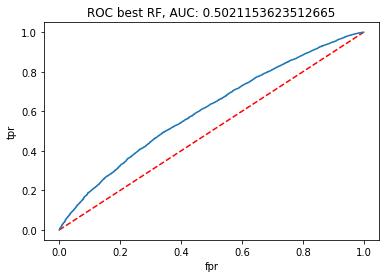

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión

In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[   30,  5681],
       [   21, 20521]])

#### Accuracy

In [69]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, predicted_labels)

0.7828057745781435

In [70]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [71]:
thresholds_2 = np.append(thresholds_2, 1)

In [72]:
(precision.shape, recall.shape, thresholds_2.shape)

((25860,), (25860,), (25860,))

#### Reporte de métricas

In [73]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [74]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.374353,0.782582,1.000000,0.878032,1.000000,0.999300,0.000700,0.000000
1,0.385535,0.782574,0.999951,0.878008,0.999951,0.999300,0.000700,0.000049
2,0.401640,0.782693,0.999951,0.878083,0.999951,0.998599,0.001401,0.000049
3,0.411713,0.782685,0.999903,0.878059,0.999903,0.998599,0.001401,0.000097
4,0.416884,0.782715,0.999903,0.878078,0.999903,0.998424,0.001576,0.000097
...,...,...,...,...,...,...,...,...
9155,0.913921,0.959184,0.002288,0.004565,0.002288,0.000350,0.999650,0.997712
9156,0.913994,0.979167,0.002288,0.004565,0.002288,0.000175,0.999825,0.997712
9157,0.916650,0.971429,0.001655,0.003305,0.001655,0.000175,0.999825,0.998345
9158,0.916708,1.000000,0.001558,0.003111,0.001558,0.000000,1.000000,0.998442


¿Cuál es el threshold que tendríamos que escoger para que no tengamos más de 6% de FP?

In [75]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
8505,0.830227,0.882796,0.125402,0.219608,0.125402,0.059884,0.940116,0.874598
8506,0.830232,0.882756,0.125353,0.219532,0.125353,0.059884,0.940116,0.874647
8507,0.830247,0.883059,0.125353,0.219541,0.125353,0.059709,0.940291,0.874647
8508,0.830280,0.882898,0.125158,0.219238,0.125158,0.059709,0.940291,0.874842
8509,0.830285,0.883202,0.125158,0.219247,0.125158,0.059534,0.940466,0.874842
...,...,...,...,...,...,...,...,...
9155,0.913921,0.959184,0.002288,0.004565,0.002288,0.000350,0.999650,0.997712
9156,0.913994,0.979167,0.002288,0.004565,0.002288,0.000175,0.999825,0.997712
9157,0.916650,0.971429,0.001655,0.003305,0.001655,0.000175,0.999825,0.998345
9158,0.916708,1.000000,0.001558,0.003111,0.001558,0.000000,1.000000,0.998442
